In [1]:
import json
import os
import re
import logging
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from nnattack.variables import auto_var, get_file_name

logging.basicConfig(level=0)

def get_result(auto_var):
    file_name = get_file_name(auto_var, name_only=True).replace("_", "-")
    file_path = f"./results/{file_name}.json"
    if not os.path.exists(file_path):
        return None
    try:
        with open(file_path, "r") as f:
            ret = json.load(f)
    except:
        print("problem with %s" % file_path)
        raise
    return ret


def params_to_dataframe(grid_param):
    params, loaded_results = auto_var.run_grid_params(get_result, grid_param, with_hook=False, verbose=0, n_jobs=1)
    results = [r['results'] if isinstance(r, dict) else r for r in loaded_results]
    params, results = zip(*[(params[i], results[i]) for i in range(len(params)) if results[i]])
    params, results = list(params), list(results)
    print(len(results))
    accs = []
    for i, param in enumerate(params):
        for r in results[i]:
            #params[i][f'eps_{r["eps"]:.2f}_trn'] = r['trn_acc']
            params[i][f'eps_{r["eps"]:.2f}_tst'] = r['tst_acc']
    df = pd.DataFrame(params)
    return df

def set_plot(fig, ax):
    fig.autofmt_xdate()
    ax.legend()
    ax.set_ylim(0, 1)
        #ax.legend(bbox_to_anchor=(1.5, 0., 0.5, 0.5))
    ax.legend()
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Adversarial Perturbation')

Using TensorFlow backend.


74
{'abalone', 'fashion_mnist06_2000_pca5', 'mnist35_2000_pca5', 'iris', 'halfmoon_2000', 'fashion_mnist35_2000_pca5', 'digits_pca5', 'wine'}
abalone
('abalone', 'knn1', 'inf', 'blackbox') 2
('abalone', 'knn1', 'inf', 'direct_k1') 2
('abalone', 'knn1', 'inf', 'kernelsub_c10000_pgd') 2
('abalone', 'knn1', 'inf', 'rev_nnopt_k1_20') 2
('abalone', 'knn1', 'inf', 'rev_nnopt_k1_50') 2


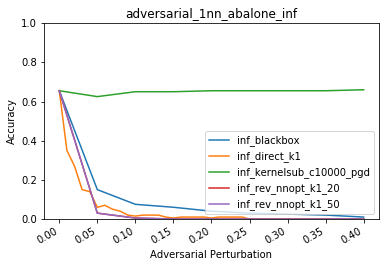

fashion_mnist06_2000_pca5
('fashion_mnist06_2000_pca5', 'knn1', 'inf', 'blackbox') 2
('fashion_mnist06_2000_pca5', 'knn1', 'inf', 'direct_k1') 2
('fashion_mnist06_2000_pca5', 'knn1', 'inf', 'kernelsub_c10000_pgd') 2
('fashion_mnist06_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_20') 2
('fashion_mnist06_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_50') 2


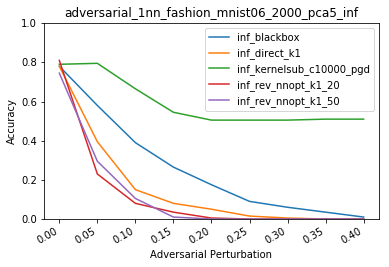

mnist35_2000_pca5
('mnist35_2000_pca5', 'knn1', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'direct_k1') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'kernelsub_c10000_pgd') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_20') 2
('mnist35_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_50') 2


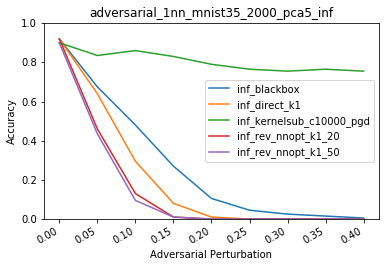

iris
('iris', 'knn1', 'inf', 'blackbox') 2
('iris', 'knn1', 'inf', 'direct_k1') 2
('iris', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('iris', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


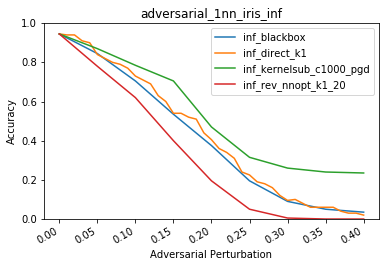

halfmoon_2000
('halfmoon_2000', 'knn1', 'inf', 'blackbox') 2
('halfmoon_2000', 'knn1', 'inf', 'direct_k1') 2
('halfmoon_2000', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('halfmoon_2000', 'knn1', 'inf', 'rev_nnopt_k1_20') 2
('halfmoon_2000', 'knn1', 'inf', 'rev_nnopt_k1_50') 2


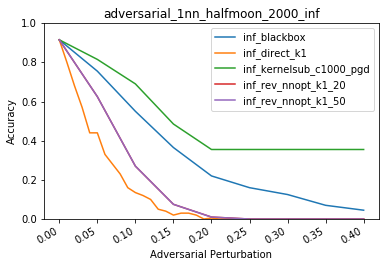

fashion_mnist35_2000_pca5
('fashion_mnist35_2000_pca5', 'knn1', 'inf', 'blackbox') 2
('fashion_mnist35_2000_pca5', 'knn1', 'inf', 'direct_k1') 2
('fashion_mnist35_2000_pca5', 'knn1', 'inf', 'kernelsub_c10000_pgd') 2
('fashion_mnist35_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_20') 2
('fashion_mnist35_2000_pca5', 'knn1', 'inf', 'rev_nnopt_k1_50') 2


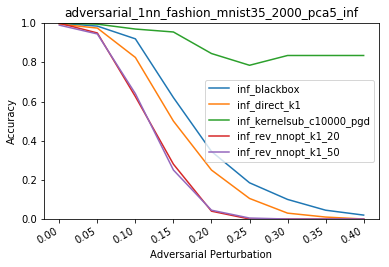

digits_pca5
('digits_pca5', 'knn1', 'inf', 'blackbox') 2
('digits_pca5', 'knn1', 'inf', 'direct_k1') 2
('digits_pca5', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('digits_pca5', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


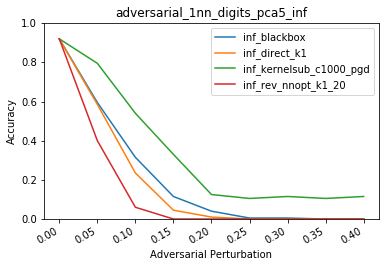

wine
('wine', 'knn1', 'inf', 'blackbox') 2
('wine', 'knn1', 'inf', 'direct_k1') 2
('wine', 'knn1', 'inf', 'kernelsub_c1000_pgd') 2
('wine', 'knn1', 'inf', 'rev_nnopt_k1_20') 2


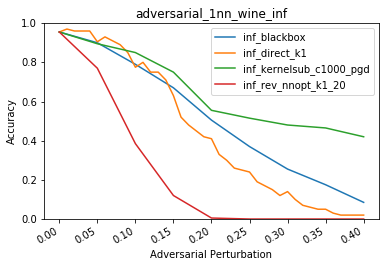

In [2]:
from params import nn_k1
exp_name = "adversarial_1nn"
_, grid_param, _ = nn_k1()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

64
{'abalone', 'digits_pca5', 'fashion_mnist06_2000_pca5', 'mnist35_2000_pca5', 'iris', 'halfmoon_2000', 'fashion_mnist35_2000_pca5', 'wine'}
abalone
('abalone', 'knn3', 'inf', 'blackbox') 2
('abalone', 'knn3', 'inf', 'direct_k3') 2
('abalone', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('abalone', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


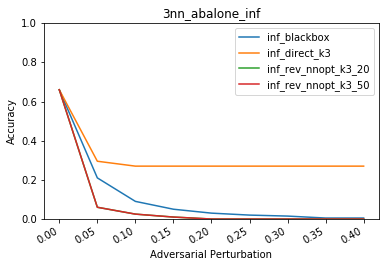

digits_pca5
('digits_pca5', 'knn3', 'inf', 'blackbox') 2
('digits_pca5', 'knn3', 'inf', 'direct_k3') 2
('digits_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('digits_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


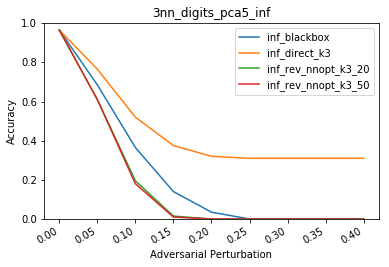

fashion_mnist06_2000_pca5
('fashion_mnist06_2000_pca5', 'knn3', 'inf', 'blackbox') 2
('fashion_mnist06_2000_pca5', 'knn3', 'inf', 'direct_k3') 2
('fashion_mnist06_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('fashion_mnist06_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


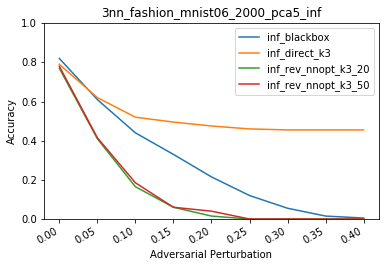

mnist35_2000_pca5
('mnist35_2000_pca5', 'knn3', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'knn3', 'inf', 'direct_k3') 2
('mnist35_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('mnist35_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


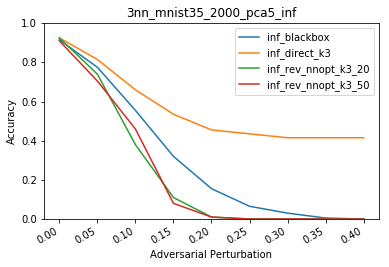

iris
('iris', 'knn3', 'inf', 'blackbox') 2
('iris', 'knn3', 'inf', 'direct_k3') 2
('iris', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('iris', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


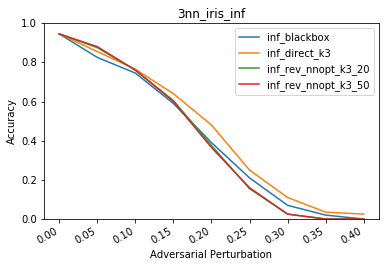

halfmoon_2000
('halfmoon_2000', 'knn3', 'inf', 'blackbox') 2
('halfmoon_2000', 'knn3', 'inf', 'direct_k3') 2
('halfmoon_2000', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('halfmoon_2000', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


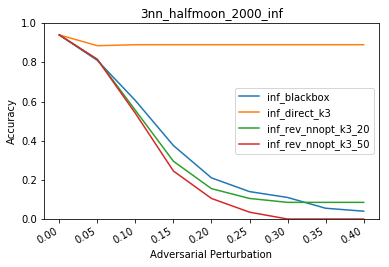

fashion_mnist35_2000_pca5
('fashion_mnist35_2000_pca5', 'knn3', 'inf', 'blackbox') 2
('fashion_mnist35_2000_pca5', 'knn3', 'inf', 'direct_k3') 2
('fashion_mnist35_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('fashion_mnist35_2000_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


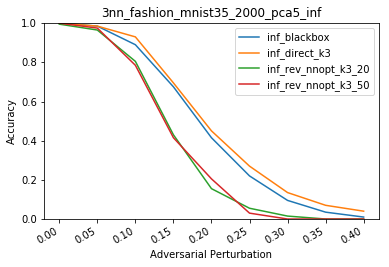

wine
('wine', 'knn3', 'inf', 'blackbox') 2
('wine', 'knn3', 'inf', 'direct_k3') 2
('wine', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('wine', 'knn3', 'inf', 'rev_nnopt_k3_50') 2


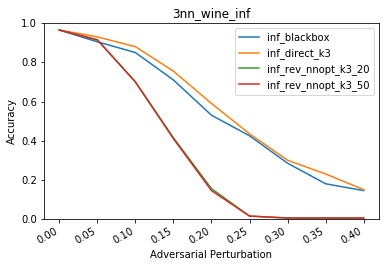

In [3]:
from params import nn_k3
exp_name = "3nn"
_, grid_param, _ = nn_k3()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

96
{'abalone', 'digits_pca5', 'fashion_mnist06_2000_pca5', 'mnist35_2000_pca5', 'iris', 'halfmoon_2000', 'fashion_mnist35_2000_pca5', 'wine'}
abalone
('abalone', 'knn5', 'inf', 'blackbox') 2
('abalone', 'knn5', 'inf', 'direct_k5') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


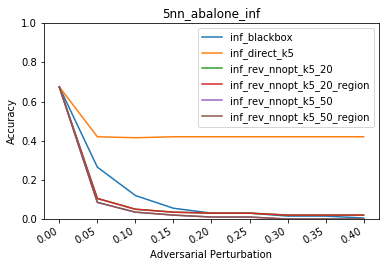

digits_pca5
('digits_pca5', 'knn5', 'inf', 'blackbox') 2
('digits_pca5', 'knn5', 'inf', 'direct_k5') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


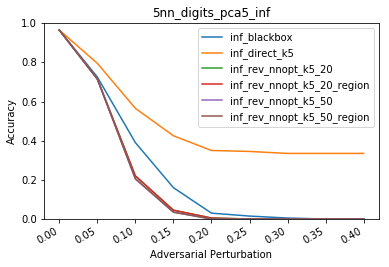

fashion_mnist06_2000_pca5
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'blackbox') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'direct_k5') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


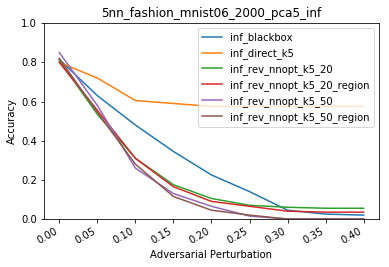

mnist35_2000_pca5
('mnist35_2000_pca5', 'knn5', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'direct_k5') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


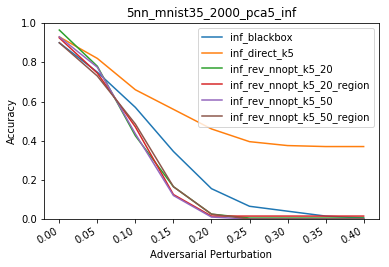

iris
('iris', 'knn5', 'inf', 'blackbox') 2
('iris', 'knn5', 'inf', 'direct_k5') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


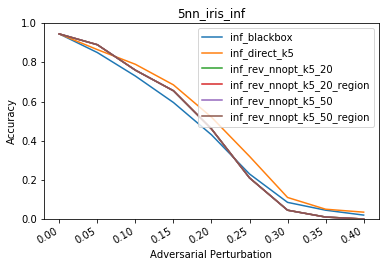

halfmoon_2000
('halfmoon_2000', 'knn5', 'inf', 'blackbox') 2
('halfmoon_2000', 'knn5', 'inf', 'direct_k5') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


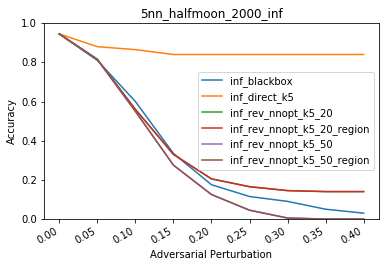

fashion_mnist35_2000_pca5
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'blackbox') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'direct_k5') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


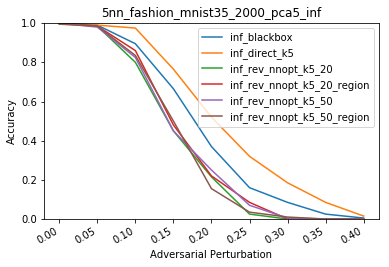

wine
('wine', 'knn5', 'inf', 'blackbox') 2
('wine', 'knn5', 'inf', 'direct_k5') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k5_20') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k5_20_region') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k5_50') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k5_50_region') 2


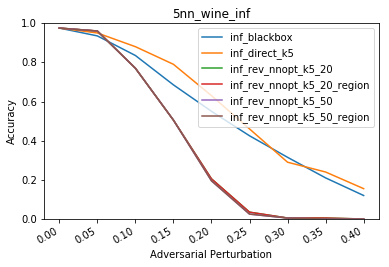

In [4]:
from params import nn_k5
exp_name = "5nn"
_, grid_param, _ = nn_k5()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

96
{'abalone', 'digits_pca5', 'fashion_mnist06_2000_pca5', 'mnist35_2000_pca5', 'iris', 'halfmoon_2000', 'fashion_mnist35_2000_pca5', 'wine'}
abalone
('abalone', 'knn5', 'inf', 'blackbox') 2
('abalone', 'knn5', 'inf', 'direct_k7') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('abalone', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


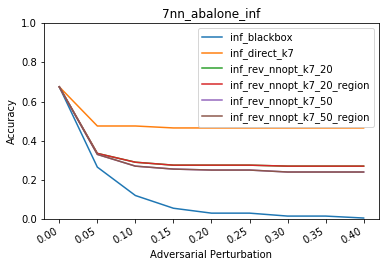

digits_pca5
('digits_pca5', 'knn5', 'inf', 'blackbox') 2
('digits_pca5', 'knn5', 'inf', 'direct_k7') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('digits_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


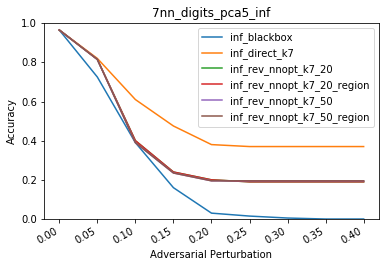

fashion_mnist06_2000_pca5
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'blackbox') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'direct_k7') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('fashion_mnist06_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


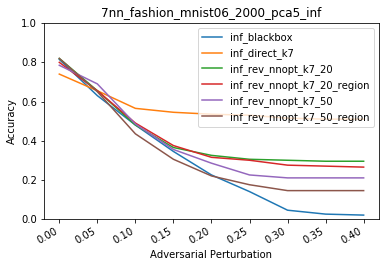

mnist35_2000_pca5
('mnist35_2000_pca5', 'knn5', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'direct_k7') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


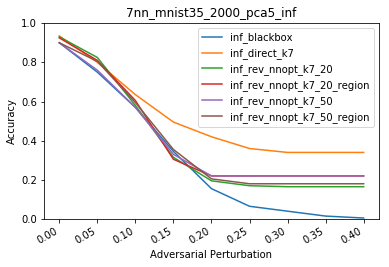

iris
('iris', 'knn5', 'inf', 'blackbox') 2
('iris', 'knn5', 'inf', 'direct_k7') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('iris', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


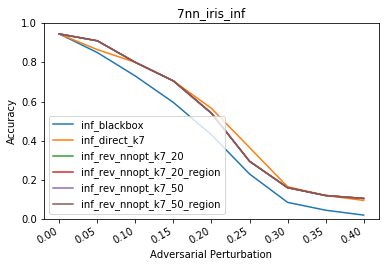

halfmoon_2000
('halfmoon_2000', 'knn5', 'inf', 'blackbox') 2
('halfmoon_2000', 'knn5', 'inf', 'direct_k7') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('halfmoon_2000', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


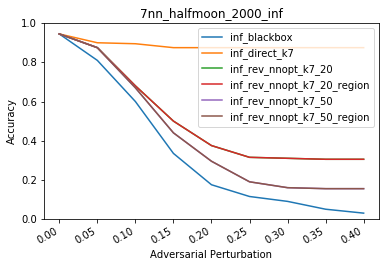

fashion_mnist35_2000_pca5
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'blackbox') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'direct_k7') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('fashion_mnist35_2000_pca5', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


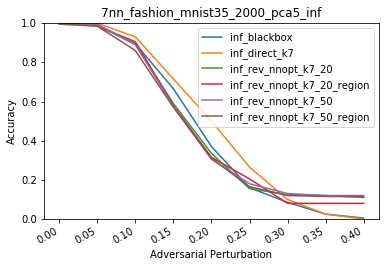

wine
('wine', 'knn5', 'inf', 'blackbox') 2
('wine', 'knn5', 'inf', 'direct_k7') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k7_20') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k7_20_region') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k7_50') 2
('wine', 'knn5', 'inf', 'rev_nnopt_k7_50_region') 2


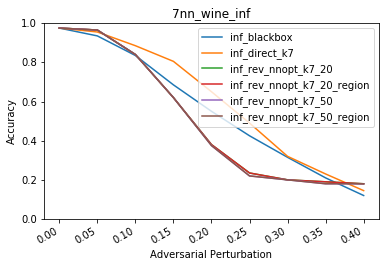

In [5]:
from params import nn_k7
exp_name = "7nn"
_, grid_param, _ = nn_k7()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

24
{'abalone', 'fashion_mnist06_2000_pca5', 'mnist35_2000_pca5', 'halfmoon_2000'}
abalone
('abalone', 'robust1nn', 'inf', 'blackbox') 2
('abalone', 'robust1nn', 'inf', 'direct_k1') 2
('abalone', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 2
('abalone', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 2


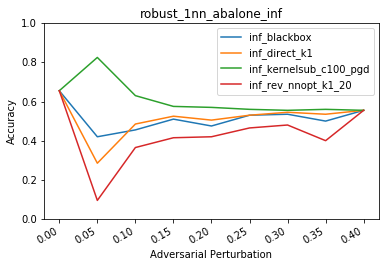

2019-03-15 11:31:56 WARNING  No handles with labels found to put in legend.


fashion_mnist06_2000_pca5


2019-03-15 11:31:56 WARNING  No handles with labels found to put in legend.


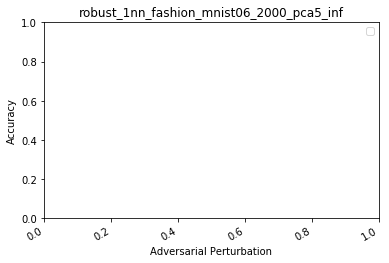

mnist35_2000_pca5
('mnist35_2000_pca5', 'robust1nn', 'inf', 'blackbox') 2
('mnist35_2000_pca5', 'robust1nn', 'inf', 'direct_k1') 2
('mnist35_2000_pca5', 'robust1nn', 'inf', 'kernelsub_c100_pgd') 2
('mnist35_2000_pca5', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 2


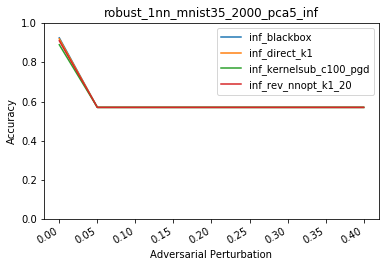

halfmoon_2000
('halfmoon_2000', 'robust1nn', 'inf', 'blackbox') 2
('halfmoon_2000', 'robust1nn', 'inf', 'direct_k1') 2
('halfmoon_2000', 'robust1nn', 'inf', 'kernelsub_c10_pgd') 2
('halfmoon_2000', 'robust1nn', 'inf', 'rev_nnopt_k1_20') 2


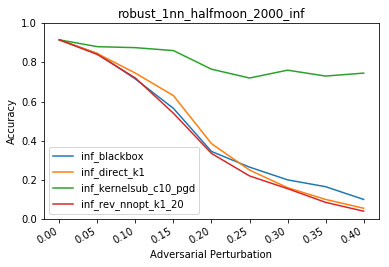

In [6]:
from params import robust_nn_k1
exp_name = "robust_1nn"
_, grid_param, _ = robust_nn_k1()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()

30
{'mnist35_200_pca5', 'halfmoon_200', 'fashion_mnist35_200_pca5'}
mnist35_200_pca5
('mnist35_200_pca5', 'knn3', 'inf', 'nnopt_k3_all') 2
('mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20_region') 2
('mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50') 2
('mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50_region') 2


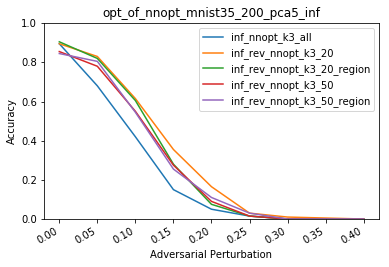

halfmoon_200
('halfmoon_200', 'knn3', 'inf', 'nnopt_k3_all') 2
('halfmoon_200', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('halfmoon_200', 'knn3', 'inf', 'rev_nnopt_k3_20_region') 2
('halfmoon_200', 'knn3', 'inf', 'rev_nnopt_k3_50') 2
('halfmoon_200', 'knn3', 'inf', 'rev_nnopt_k3_50_region') 2


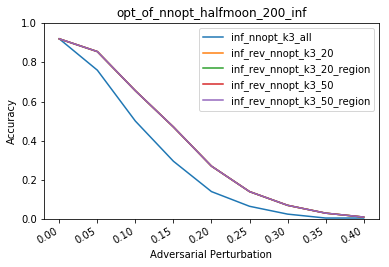

fashion_mnist35_200_pca5
('fashion_mnist35_200_pca5', 'knn3', 'inf', 'nnopt_k3_all') 2
('fashion_mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20') 2
('fashion_mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_20_region') 2
('fashion_mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50') 2
('fashion_mnist35_200_pca5', 'knn3', 'inf', 'rev_nnopt_k3_50_region') 2


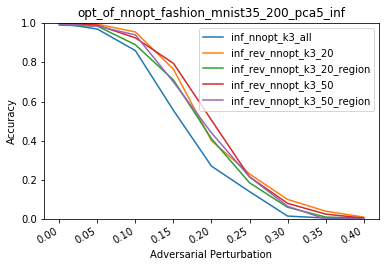

In [7]:
from params import opt_of_nnopt
exp_name = "opt_of_nnopt"
_, grid_param, _ = opt_of_nnopt()

df = params_to_dataframe(grid_param)
datasets = set.union(*[set(g['dataset']) for g in grid_param]) if isinstance(grid_param, list) else grid_param['dataset']
print(datasets)
for dataset in datasets:
    print(dataset)
    for ord in grid_param[0]['ord']:
        temp_df = df.loc[(df['dataset'] == dataset) & (df['ord'] == ord)]
        fig, ax = plt.subplots()
        ax.set_title(f'{exp_name}_{dataset}_{ord}')
        for name, group in temp_df.groupby(['dataset', 'model', 'ord', 'attack']):
            print(name, len(group))
            eps_list = [re.findall(r'[-+]?\d*\.\d+|\d+', t)[0] for t in group.mean().index.tolist()[:-1]]
            s = [r for r in group.mean().tolist()[:-1] if not np.isnan(r)]
            x = [float(eps_list[i]) for i, r in enumerate(group.mean().tolist()[:-1]) if not np.isnan(r)]

            ax.plot(x, s, label="%s_%s" % (name[2], name[-1]))

        set_plot(fig, ax)
        plt.savefig(f'./figs/{exp_name}_{dataset}_{ord}.eps', format='eps')
        plt.show()